In [3]:
import json
metadata_file_path = '/data/hf_repos/the-stak-repo-level/meta_data/java/1K_20plus_near_dedup_unique_files_by_repo_commit.json'
# data has repo_name as key and for each repo and each commit within the repo, we have the relative file paths.
data = json.loads(open(metadata_file_path).read())

Check if any repository has more than one commits. If this is the case, we need to choose one of the commits (ideally the latest one if that data is available. if not, then we should chose randomly). If all of the repos have one commit, we proceed to the next step. In addition, we also check if there are any empty repos.

In [4]:
count_non_empty_repos = 0
for repo_name, commit in data.items():
    len_commits = len(commit.keys())
    if len_commits > 1:
        print(repo_name, len_commits)
    if len_commits == 1:
        count_non_empty_repos += 1
assert count_non_empty_repos == len(data)

Calculate the total number of files.

In [5]:
repo_file_mapping = {}
total_files = 0
for repo_name, commit in data.items():
    for commit_id, files in commit.items():
        repo_file_mapping[repo_name] = files
        total_files += len(files)
print('Total #files: ', total_files)          

Total #files:  105377


Distribution of number of files across repositories.

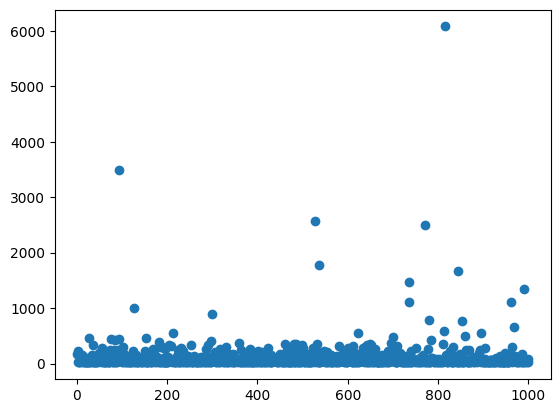

In [6]:
import matplotlib.pyplot as plt
repo_filelen_mapping = {}
count = 0
for repo_name, files in repo_file_mapping.items():
    count += 1
    repo_filelen_mapping[count] = len(files)
plt.scatter(list(repo_filelen_mapping.keys()), repo_filelen_mapping.values())
plt.show()


In [7]:
all_filelens = list(repo_filelen_mapping.values())
print("Mean #files", sum(all_filelens)/len(all_filelens))
print("Max #files", max(all_filelens))
print("Min #files: ", min(all_filelens))

Mean #files 105.377
Max #files 6078
Min #files:  20


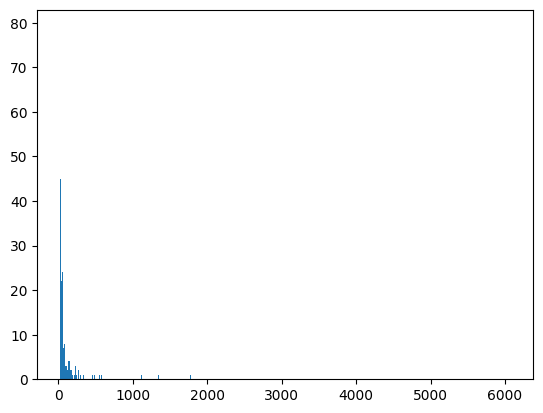

In [8]:
plt.hist(all_filelens, bins=3000)
plt.show()

Calculater total #lines and total #tokens as well as total #code lines and total #code tokens.

In [9]:
# This is a mapping from the repo_name to the bucket ID. There are fewer buckets than #repos.
repo_bucket_mapping = json.loads(open('/data/hf_repos/the-stak-repo-level/meta_data/java/1K_20plus_repo_2_bucket.json').read())
len(repo_bucket_mapping)

1000

In [12]:
import os
import numpy as np
base_dir = '/data/hf_repos/the-stak-repo-level/data/java/'

def get_line_and_token_count(repo_name, file_path):
    bucket_id = repo_bucket_mapping[repo_name]
    commit_id = list(data[repo_name].keys())[0]
    # to get the complete file path we need the bucket to which the repo belongs to and then the repo name and then the commit id and then the relative file path.
    complete_file_path = os.path.join(base_dir, str(bucket_id), repo_name, commit_id, file_path)
    code_line_count = 0
    with open(complete_file_path) as f:
        lines = f.readlines()
        line_count = len(lines)
        token_count = 0
        code_token_count = 0
        for line in lines:
            token_count += len(line.split())
            # count only uncoomented and non-empty lines.
            line = line.strip()
            if line and not(np.any([line.startswith(c) for c in ['*', '/']])):
                code_line_count += 1
                code_token_count += len(line.split())               
    return line_count, token_count, code_line_count, code_token_count

total_line_count = 0
total_token_count = 0
total_code_line_count = 0
total_code_token_count = 0
repo_hole_mapping = {}
for repo_name, files in repo_file_mapping.items():
    repo_hole_count = 0
    for file in files:
        line_count, token_count, code_line_count, code_token_count = get_line_and_token_count(repo_name, file)
        total_line_count += line_count
        total_token_count += token_count
        total_code_line_count += code_line_count
        repo_hole_count += code_line_count
        total_code_token_count += code_token_count
    repo_hole_mapping[repo_name] = repo_hole_count
print("Total #Lines: ", total_line_count)
print("Total #Code Lines: ", total_code_line_count)
print("Total #Tokens:", total_token_count)
print("Total #Code Tokens:", total_code_token_count)

Total #Lines:  13321492
Total #Code Lines:  8975045
Total #Tokens: 40731588
Total #Code Tokens: 27504310


Distribution of holes 

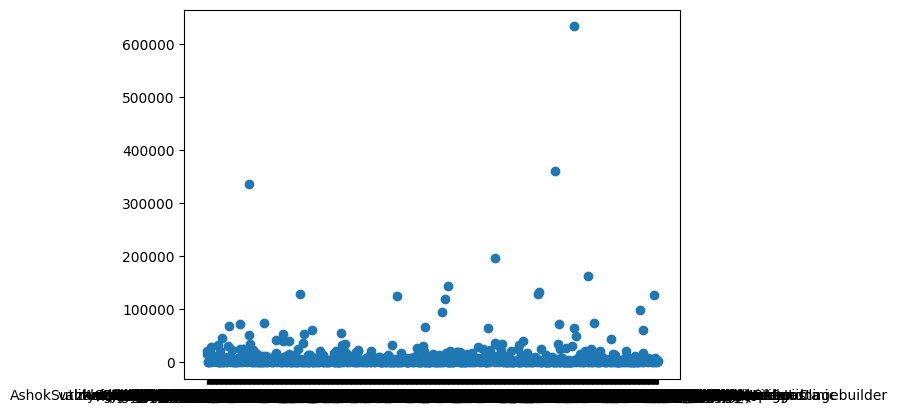

In [13]:
plt.scatter(repo_hole_mapping.keys(), repo_hole_mapping.values())
plt.show()

In [20]:
print("Mean #holes", sum(repo_hole_mapping.values())/len(repo_hole_mapping))
print("Max #holes", max(repo_hole_mapping.values()))
print("Min #holes: ", min(repo_hole_mapping.values()))


Mean #holes 8975.045
Max #holes 633051
Min #holes:  214


Split into train, val and test and rewrite in a directory form

In [24]:
import random
random.seed(42)
all_repos = list(repo_hole_mapping.keys())
random.shuffle(all_repos)
train_repos = all_repos[:600]
val_repos = all_repos[600:800]
test_repos = all_repos[800:]

train_repos[:10], val_repos[:5], test_repos[:5]

(['wiverson/crash-dummy',
  '1823616178/love_remote_link',
  'wobushiren79/VedioChat',
  'hifeego/easyexcel',
  'madanalogy/IncidentManager',
  'sidpatel-github/java-generics',
  'zhangqx1994/mybatisToMongodb',
  'Notronix/JaLAPI',
  'wvdschel/twitsy',
  'qsxzaqq/UHC'],
 ['dhfbk/KD',
  'Haven-King/Automotion',
  'Qi4j/qi4j-libraries',
  'RenCloud/AstralEdit',
  'michal880/zadania-spring'],
 ['superSoulfy/adr-center',
  'instacount/appengine-counter',
  'Lupus590/copy-cat',
  'shuli495/pighand-framework',
  'Dilolokko/testinium-plugin'])

In [26]:
len(train_repos), len(val_repos), len(test_repos)

(600, 200, 200)

In [25]:
import shutil
destination_base_dir = '/home/toolkit/repo_preprocessed_data/'
def copy_repos(repo_name, data_split):
    bucket_id = repo_bucket_mapping[repo_name]
    commit_id = list(data[repo_name].keys())[0]
    source_dir = os.path.join(base_dir, str(bucket_id), repo_name, commit_id)
    destination_dir = os.path.join(destination_base_dir, data_split)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copytree(source_dir, os.path.join(destination_dir, repo_name))

for repo in train_repos:
    copy_repos(repo, 'train')
for repo in val_repos:
    copy_repos(repo, 'val')
for repo in test_repos:
    copy_repos(repo, 'test')


Log all the unique files inside the repo folder. Holes would be created only from the unique files.

In [35]:
destination_base_dir = '/home/toolkit/repo_preprocessed_data/'
def get_split(repo_name):
    if repo_name in train_repos:
        return 'train'
    elif repo_name in val_repos:
        return 'val'
    else:
        return 'test'

for repo_name, entries in data.items():
    split = get_split(repo_name)
    output_dir = os.path.join(destination_base_dir, split, repo_name)
    f = open(os.path.join(output_dir, 'unique_files.txt'), 'w')
    for commit_id, files in entries.items():
        for file in files:
            f.write(os.path.join(output_dir, file) + '\n')
    f.close()
            